## average fixated gaze distance from AOI

In [75]:
# imports
# imports

import numpy as np
import pandas as pd
# %matplotlib widget
# %matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.cm as cm
from matplotlib.animation import FuncAnimation
import itertools
import random
import seaborn as sns
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.d03_processing.BlinkProcessor import BlinkProcessor
from src.d03_processing.fixations.SignalProcessor import SignalProcessor
from src.d03_processing.fixations.I_VDT import I_VDT
from src.d00_utils.TaskObjects import *
from src.d03_processing.fixations.FixationProcessor import FixationProcessor
from src.d03_processing.TimepointProcessor import TimepointProcessor
from src.d01_data.fetch.fetch_timepoints import fetch_timepoints
from src.d01_data.fetch.fetch_viewings import fetch_viewings
from src.d01_data.fetch.fetch_trials import fetch_trials
from src.d01_data.fetch.fetch_timepoints import fetch_timepoints
from src.d03_processing.aoi import collision_sphere_radius
from src.d03_processing.feature_extract.to_viewing import to_viewing
from src.d03_processing.preprocess import preprocess_timepoints
from src.d03_processing.fixations.FixAlgos import *
from src.d00_utils.TaskObjects import *

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.linalg import orthogonal_procrustes
from scipy.spatial.distance import cdist
from scipy.spatial import procrustes

In [152]:
# get processed timepoints
# get viewings
n = 100
# all_trials = pd.read_csv("C:\\Users\\Luke\\Documents\\AlloEye\\data\\feature_saves\\all_real_trials.csv")
all_trials = fetch_trials("all")
# n = len(all_trials)
n_trials = len(all_trials)
print(n_trials)
r_inds = np.random.randint(0, n_trials, n)
rand_trials = list(all_trials.trial_id.to_numpy()[r_inds])

# # temp while bug fixed
# for t in rand_trials:
#     if '21r2' in t:
#         rand_trials.remove(t)
        
viewings = []
for t in rand_trials:
    viewings.append(f"{t}_enc")
    viewings.append(f"{t}_ret")
print(viewings)
# viewings = ['alloeye_10r1_16_enc']
timepoints = fetch_timepoints("all", viewing_id=viewings, suppress_print=True)
print(timepoints.shape)

fix_algos = ['GazeCollision']
fix_algos_process = {i: fix_algo_dict()[i] for i in fix_algos}

fix_tps = []
full_tps = None
n_viewings = len(viewings)
# preprocess
for i in range(n_viewings):
    # ind = random.randint(0, len(viewings)-1)
    viewing = viewings[i]
    # viewing = "alloeye_52r2_17_ret"

    # print(viewing)
    tps = timepoints[timepoints.viewing_id == viewing].reset_index(drop=True)
    tps, skip = preprocess_timepoints(tps, 0.25)
    if skip:
        fix_tps.append(None)
        continue
    
    # p_tps.append(tps)
    # full_tps = tps if full_tps is None else pd.concat([full_tps, tps], ignore_index=True)
    for name, _class in fix_algos_process.items():
        instance = _class(tps)
        tps['fixation'] = instance.timepoints.fixation
    
    fix_tps.append(tps.copy(deep=True))

4355
['alloeye_101r2_9_enc', 'alloeye_101r2_9_ret', 'alloeye_21r3_5_enc', 'alloeye_21r3_5_ret', 'alloeye_26r3_10_enc', 'alloeye_26r3_10_ret', 'alloeye_78r1_3_enc', 'alloeye_78r1_3_ret', 'alloeye_58r2_5_enc', 'alloeye_58r2_5_ret', 'alloeye_19r3_3_enc', 'alloeye_19r3_3_ret', 'alloeye_19r2_1_enc', 'alloeye_19r2_1_ret', 'alloeye_22r1_12_enc', 'alloeye_22r1_12_ret', 'alloeye_33r2_7_enc', 'alloeye_33r2_7_ret', 'alloeye_41r3_0_enc', 'alloeye_41r3_0_ret', 'alloeye_58r3_6_enc', 'alloeye_58r3_6_ret', 'alloeye_73r3_3_enc', 'alloeye_73r3_3_ret', 'alloeye_55r2_3_enc', 'alloeye_55r2_3_ret', 'alloeye_46r1_16_enc', 'alloeye_46r1_16_ret', 'alloeye_21r3_14_enc', 'alloeye_21r3_14_ret', 'alloeye_20r1_16_enc', 'alloeye_20r1_16_ret', 'alloeye_6r2_10_enc', 'alloeye_6r2_10_ret', 'alloeye_10r1_1_enc', 'alloeye_10r1_1_ret', 'alloeye_60r2_11_enc', 'alloeye_60r2_11_ret', 'alloeye_7r3_4_enc', 'alloeye_7r3_4_ret', 'alloeye_48r2_15_enc', 'alloeye_48r2_15_ret', 'alloeye_75r1_17_enc', 'alloeye_75r1_17_ret', 'alloeye_3

C:\Users\Luke Emrich-Mills\OneDrive\Documents\PhD\AlloEye\data_pipeline\src\d03_processing\fixations\GazeCollision.py:95: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  (fix_objects == "Table") & \
C:\Users\Luke Emrich-Mills\OneDrive\Documents\PhD\AlloEye\data_pipeline\src\d03_processing\fixations\GazeCollision.py:95: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  (fix_objects == "Table") & \
C:\Users\Luke Emrich-Mills\OneDrive\Documents\PhD\AlloEye\data_pipeline\src\d03_processing\fixations\GazeCollision.py:95: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  (fix_objects == "Table") & \
C:\Users\Luke Emrich-Mills\OneDrive\Documents\PhD\AlloEye\data_pipeline\src\d03_processing\fixations\GazeCollision.py:95: FutureWarning: elementwise comparison fai

In [153]:
from scipy.spatial.distance import cdist

def gaussian_score(x, a=1, b=0, c=1):
    return a * np.exp(-((x-b)**2) / (2 * c**2))

def distances_from_point(tps, point):
    distances = np.sqrt(np.sum((tps - point)**2, axis=1))
    return distances

def get_projected_centroid(timepoints, trial):

    # get mean head point for projecting to 2d
    head_mat = TimepointProcessor.create_head_loc_matrix(timepoints)
    mean_head = np.mean(head_mat, axis=0)

    # get object positions and project to 2d
    proj_points = []
    for i in [1, 2, 3, 4]:
        obj = trial[f"obj{i}_name"].values[0]
        y_offset = TaskObjects.collider_y_offset[obj]
        point = np.array([trial[f"obj{i}_{prepostshift}_x"].values[0], 0.7 + y_offset, trial[f"obj{i}_{prepostshift}_z"].values[0]])
        proj_point = FixationProcessor.head_project(point.reshape(1, -1), mean_head, use_headlocmat_as_mean=True)
        proj_points.append(proj_point)

    # calculate centroid
    proj_points = np.array(proj_points)
    centroid_2d = np.mean(proj_points, axis=0)
    # print("centroid", centroid_2d)

    return centroid_2d


def gaze_distance_centroid_2d(timepoints, trial, cutoff=1, plot_debug=False):

    tps = timepoints.copy(deep=True)

    # filter and sort timepoints
    fixation_tps = tps[tps.fixation == 1].sort_values(by='eye_timestamp_ms').reset_index(drop=True)

    # assume timepoint from one viewing
    viewing_id = fixation_tps.viewing_id.values[0]
    prepostshift = 'preshift' if viewing_id[-3:] == 'enc' else 'postshift'

    # convert gaze point and head points to numpy
    point_mat = TimepointProcessor.create_gaze_point_matrix(fixation_tps)
    head_mat = TimepointProcessor.create_head_loc_matrix(fixation_tps)

    # get mean head point for projecting to 2d
    mean_head = np.mean(head_mat, axis=0)

    # get object positions and project to 2d
    proj_points = []
    for i in [1, 2, 3, 4]:
        obj = trial[f"obj{i}_name"].values[0]
        y_offset = TaskObjects.collider_y_offset[obj]
        point = np.array([trial[f"obj{i}_{prepostshift}_x"].values[0], 0.7 + y_offset, trial[f"obj{i}_{prepostshift}_z"].values[0]])
        proj_point = FixationProcessor.head_project(point.reshape(1, -1), mean_head, use_headlocmat_as_mean=True)
        proj_points.append(proj_point)

    # project gaze and mean head point to 2d
    proj_tps = FixationProcessor.head_project(point_mat, mean_head, use_headlocmat_as_mean=True)

    # calculate centroid
    proj_points = np.array(proj_points)
    centroid_2d = np.mean(proj_points, axis=0)
    # print("centroid", centroid_2d)

    # get distances

    distances = distances_from_point(proj_tps, centroid_2d)

    # plot debug
    if plot_debug:
        # 3d scatter
        gp_x, gp_y, gp_z = proj_tps.T
        ax3d= plt.figure(figsize=[5, 3]).add_subplot(projection='3d')
        ax3d.plot(gp_x, gp_z, gp_y, 'r.',)
        ax3d.plot(centroid_2d[:, 0], centroid_2d[:, 2], centroid_2d[:, 1], 'bx')
        plt.show()
        # density plot
        fig = plt.figure(figsize=[5,3])
        ax = sns.kdeplot(data=np.array(distances))
        ax.axvline(np.nanmean(distances), c='g')
        plt.show()

    return distances


def gaze_distances_from_point(from_this_point, timepoints, fixation_only=True, cutoff=1.0, plot_debug=False):
    tps = timepoints.copy()
    # filter and sort timepoints

    # fixation_tps = tps[tps.fixation == 1].sort_values(by='eye_timestamp_ms').reset_index(drop=True)
    # print('fix', fixation_tps.shape)
    # convert gaze point and head points to numpy
    point_mat = TimepointProcessor.create_gaze_point_matrix(tps)

    head_mat = TimepointProcessor.create_head_loc_matrix(tps)
    
    # get mean head point for projecting to 2d
    mean_head = np.mean(head_mat, axis=0)
    
    # project gaze and mean head point to 2d
    proj_point = FixationProcessor.head_project(from_this_point.reshape(1, -1), mean_head, use_headlocmat_as_mean=True)
    proj_tps = FixationProcessor.head_project(point_mat, mean_head, use_headlocmat_as_mean=True)


    # calculated distance between projected gaze points and projected reference point
    distances = distances_from_point(proj_tps, proj_point)
    # print('precut', distances.shape)
    if cutoff is not None:
        distances = distances[distances < cutoff]   #  apply cutoff
    # print('postcut', distances.shape)

    # plot debug
    if plot_debug:
        # 3d scatter
        gp_x, gp_y, gp_z = proj_tps.T
        ax3d= plt.figure(figsize=[5, 3]).add_subplot(projection='3d')
        ax3d.plot(gp_x, gp_z, gp_y, 'r.',)
        ax3d.plot(proj_point[:, 0], proj_point[:, 2], proj_point[:, 1], 'bx')
        
        # density plot
        fig = plt.figure(figsize=[5,3])
        ax = sns.set_style('whitegrid')
        ax = sns.kdeplot(data=np.array(distances))
        ax.axvline(np.nanmean(distances), c='g')
        plt.show()
        
    return distances


def get_distances_from_border(timepoints, trial, tabletop_radius=0.55, border_thickness=0.12, cutoff=1.0, plot_debug=False):
    tps = timepoints.copy(deep=True)
    # Adjust the tabletop_radius
    tabletop_radius_adjusted_in = tabletop_radius - border_thickness
    tabletop_radius_adjusted_out = tabletop_radius
    
    # get the tabletop centre from trial info
    trial = trial.reset_index(drop=True)
    table_top_center = np.array([trial.table_location_x[0], 0.7, trial.table_location_z[0]])
    
    # filter and sort timepoints
    fixation_tps = tps[tps.fixation == 1].sort_values(by='eye_timestamp_ms').reset_index(drop=True)
    
    # convert gaze point and head points to numpy
    point_mat = TimepointProcessor.create_gaze_point_matrix(fixation_tps)
    not_nans = ~np.isnan(point_mat).any(axis=1)
    point_mat = point_mat[not_nans]
    head_mat = TimepointProcessor.create_head_loc_matrix(fixation_tps)
    not_nans = ~np.isnan(head_mat).any(axis=1)
    head_mat = head_mat[not_nans]
    # print(head_mat)
    
    
    # get mean head point for projecting to 2d
    mean_head = np.mean(head_mat, axis=0)
    
    # project gaze and mean head point to 2d
    proj_table = FixationProcessor.head_project(table_top_center.reshape(1, -1), mean_head, use_headlocmat_as_mean=True)
    proj_tps = FixationProcessor.head_project(point_mat, mean_head, use_headlocmat_as_mean=True)
    # print(proj_tps)
    # # Calculate the projection of gaze points on tabletop plane
    # projected_points = np.copy(gaze_points)
    # projected_points[:, 2] = tabletop_center[2] # The z-coordinate of the projected points is the same as the tabletop center

    # Calculate the distance from the projected points to the center of the table
    distance_to_center = np.linalg.norm(proj_tps - proj_table, axis=1)
    # print(distance_to_center)

    # Create the array for closest points on the tabletop border
    closest_points_on_border = np.copy(proj_tps)

    # If the distance is less than the inner adjusted tabletop's radius
    mask_in = distance_to_center < tabletop_radius_adjusted_in
    closest_points_on_border[mask_in] = proj_table + (tabletop_radius_adjusted_in / distance_to_center[mask_in])[:, None] * (proj_tps[mask_in] - proj_table)
    
    
    # If the distance is greater than the outer adjusted tabletop's radius
    mask_out = distance_to_center > tabletop_radius_adjusted_out
    closest_points_on_border[mask_out] = proj_table + (tabletop_radius_adjusted_out / distance_to_center[mask_out])[:, None] * (proj_tps[mask_out] - proj_table)

    # If the distance is between the inner and outer adjusted tabletop's radius, the gaze point is already within the border
    mask_border = ~(mask_in | mask_out)
    closest_points_on_border[mask_border] = proj_tps[mask_border]
    # print(proj_tps)
    # print(closest_points_on_border)
    # Calculate the distance from the gaze point to the closest point on the tabletop border
    distances = np.linalg.norm(proj_tps - closest_points_on_border, axis=1)
    distances = distances[distances < cutoff]   #  apply cutoff
    
        # plot debug
    if plot_debug:
        # 3d scatter
        gp_x, gp_y, gp_z = proj_tps.T
        ax3d= plt.figure(figsize=[5, 3]).add_subplot(projection='3d')
        ax3d.plot(gp_x, gp_z, gp_y, 'r.',)
        ax3d.plot(proj_table[:, 0], proj_table[:, 2], proj_table[:, 1], 'bx')
        
        # density plot
        fig = plt.figure(figsize=[5,3])
        ax = sns.set_style('whitegrid')
        ax = sns.kdeplot(data=np.array(distances))
        ax.axvline(np.nanmedian(distances), c='g')
        plt.show()

    return distances



def gaze_duration_gaussian_centroid(timepoints, trial=None, c=0.1, fix_algo='GazeCollision'):
    # get trial row if none
    if trial is None:
        trial_id = timepoints.trial_id.values[0]
        trial = fetch_trials("all", trial_ids=[trial_id], suppress_print=True, remove_training_trials=False,
                             practice=[False, True])
    centroid = get_projected_centroid(timepoints, trial)
    return gaze_duration_gaussian_point(timepoints, centroid, c=c, fix_algo=fix_algo)


def gaze_duration_gaussian_pp(timepoints, trial=None, c=0.1, fix_algo='GazeCollision'):

    if trial is None:
        trial_id = timepoints.trial_id.values[0]
        trial = fetch_trials("all", trial_ids=[trial_id], suppress_print=True, remove_training_trials=False,
                         practice=[False, True])

    viewing_id = timepoints.viewing_id.values[0]

    if 'enc' in viewing_id:
        return None

    # get previous position location
    obj1_name = trial.obj1_name[0]
    point_pp = np.array([trial.obj1_preshift_x[0],
                         TaskObjects.collider_y_offset[obj1_name] + 0.7,
                         trial.obj1_preshift_z[0]])

    return gaze_duration_gaussian_point(timepoints, point_pp, c=0.1, fix_algo='GazeCollision')


def gaze_duration_gaussian_point(timepoints, point, c=0.1, fix_algo='GazeCollision'):
    if 'fixation' not in timepoints.columns:
        timepoints['fixation'] = fix_algo_dict()[fix_algo](timepoints).timepoints.fixation
    tps = timepoints.copy()[timepoints.fixation == 1].sort_values(by='eye_timestamp_ms')
    return gaze_duration_gaussian(tps, point, c=c)


def gaze_duration_gaussian(tps, point, c=0.1):
    tps = tps.copy()

    distances = gaze_distances_from_point(point, tps, cutoff=None)  # set cutoff to None to avoid using
    t_diffs = np.append(0, np.diff(tps.eye_timestamp_ms.to_numpy()))

    mask = pd.isna(distances)
    distances = distances[~mask]
    t_diffs = t_diffs[~mask]

    gauss_ = gaussian_score(distances, a=t_diffs, c=c)
    return gauss_


In [156]:
# gd == gaussian-weighted duration

gd_centroids = []
sum_gd_centroid = []
gd_pps =[]
sum_gd_pps = []
for i in range(len(fix_tps)):
    tps = fix_tps[i]
    if tps is None:

        print('skipping')
        continue
    trial_id = tps.trial_id.values[0]

    trial = all_trials[all_trials.trial_id == trial_id].reset_index(drop=True)
    gd_cs = gaze_duration_gaussian_centroid(tps, trial, c=0.15)
    gd_centroids.append(gd_cs)
    sum_gd_centroid.append(np.nansum(gd_cs))

    gd_ps = gaze_duration_gaussian_pp(tps, trial, c=0.12)

    if gd_ps is not None:
        gd_pps.append(gd_ps)
    sum_gd_pps.append(np.nansum(gd_ps))




C:\Users\Luke Emrich-Mills\OneDrive\Documents\PhD\AlloEye\data_pipeline\src\d03_processing\fixations\FixationProcessor.py:386: RuntimeWarning: invalid value encountered in divide
  norm = v / np.linalg.norm(v)
C:\Users\Luke Emrich-Mills\OneDrive\Documents\PhD\AlloEye\data_pipeline\src\d03_processing\fixations\FixationProcessor.py:386: RuntimeWarning: invalid value encountered in divide
  norm = v / np.linalg.norm(v)


skipping
skipping
skipping
skipping


C:\Users\Luke Emrich-Mills\OneDrive\Documents\PhD\AlloEye\data_pipeline\src\d03_processing\fixations\FixationProcessor.py:386: RuntimeWarning: invalid value encountered in divide
  norm = v / np.linalg.norm(v)
C:\Users\Luke Emrich-Mills\OneDrive\Documents\PhD\AlloEye\data_pipeline\src\d03_processing\fixations\FixationProcessor.py:386: RuntimeWarning: invalid value encountered in divide
  norm = v / np.linalg.norm(v)
C:\Users\Luke Emrich-Mills\OneDrive\Documents\PhD\AlloEye\data_pipeline\src\d03_processing\fixations\FixationProcessor.py:386: RuntimeWarning: invalid value encountered in divide
  norm = v / np.linalg.norm(v)
C:\Users\Luke Emrich-Mills\OneDrive\Documents\PhD\AlloEye\data_pipeline\src\d03_processing\fixations\FixationProcessor.py:386: RuntimeWarning: invalid value encountered in divide
  norm = v / np.linalg.norm(v)
C:\Users\Luke Emrich-Mills\OneDrive\Documents\PhD\AlloEye\data_pipeline\src\d03_processing\fixations\FixationProcessor.py:386: RuntimeWarning: invalid value enc

skipping


C:\Users\Luke Emrich-Mills\OneDrive\Documents\PhD\AlloEye\data_pipeline\src\d03_processing\fixations\FixationProcessor.py:386: RuntimeWarning: invalid value encountered in divide
  norm = v / np.linalg.norm(v)
C:\Users\Luke Emrich-Mills\OneDrive\Documents\PhD\AlloEye\data_pipeline\src\d03_processing\fixations\FixationProcessor.py:386: RuntimeWarning: invalid value encountered in divide
  norm = v / np.linalg.norm(v)
C:\Users\Luke Emrich-Mills\OneDrive\Documents\PhD\AlloEye\data_pipeline\src\d03_processing\fixations\FixationProcessor.py:386: RuntimeWarning: invalid value encountered in divide
  norm = v / np.linalg.norm(v)
C:\Users\Luke Emrich-Mills\OneDrive\Documents\PhD\AlloEye\data_pipeline\src\d03_processing\fixations\FixationProcessor.py:386: RuntimeWarning: invalid value encountered in divide
  norm = v / np.linalg.norm(v)
C:\Users\Luke Emrich-Mills\OneDrive\Documents\PhD\AlloEye\data_pipeline\src\d03_processing\fixations\FixationProcessor.py:386: RuntimeWarning: invalid value enc

skipping


C:\Users\Luke Emrich-Mills\OneDrive\Documents\PhD\AlloEye\data_pipeline\src\d03_processing\fixations\FixationProcessor.py:386: RuntimeWarning: invalid value encountered in divide
  norm = v / np.linalg.norm(v)
C:\Users\Luke Emrich-Mills\OneDrive\Documents\PhD\AlloEye\data_pipeline\src\d03_processing\fixations\FixationProcessor.py:386: RuntimeWarning: invalid value encountered in divide
  norm = v / np.linalg.norm(v)
C:\Users\Luke Emrich-Mills\OneDrive\Documents\PhD\AlloEye\data_pipeline\src\d03_processing\fixations\FixationProcessor.py:386: RuntimeWarning: invalid value encountered in divide
  norm = v / np.linalg.norm(v)
C:\Users\Luke Emrich-Mills\OneDrive\Documents\PhD\AlloEye\data_pipeline\src\d03_processing\fixations\FixationProcessor.py:386: RuntimeWarning: invalid value encountered in divide
  norm = v / np.linalg.norm(v)
C:\Users\Luke Emrich-Mills\OneDrive\Documents\PhD\AlloEye\data_pipeline\src\d03_processing\fixations\FixationProcessor.py:386: RuntimeWarning: invalid value enc

<Axes: ylabel='Density'>

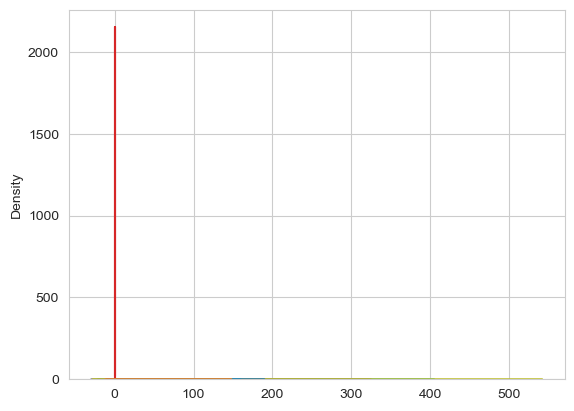

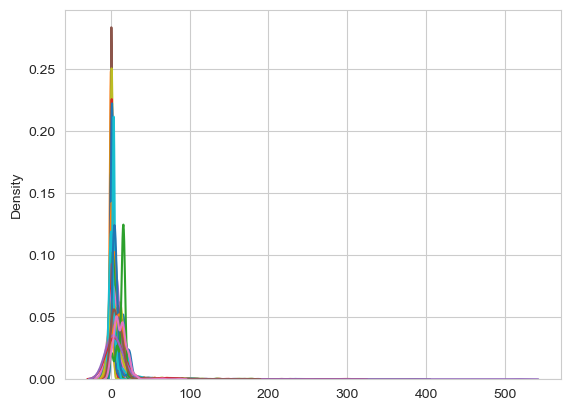

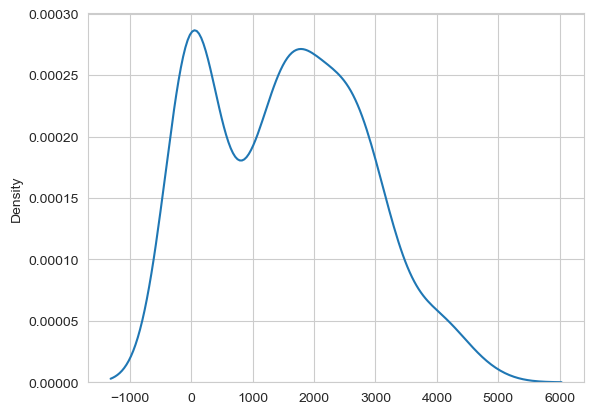

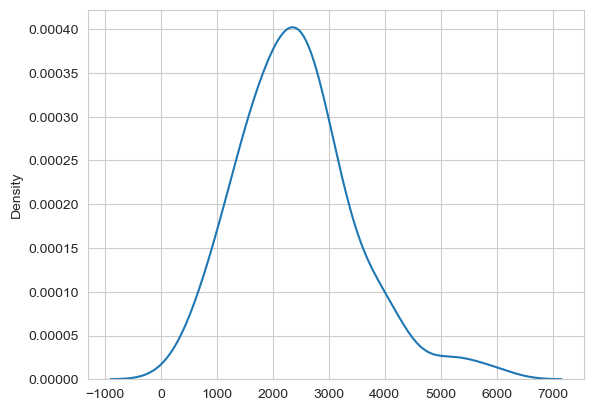

In [157]:
ax = plt.figure().add_subplot()
for i in range(len(gd_centroids)):
    sns.kdeplot(gd_centroids[i])
ax = plt.figure().add_subplot()
for i in range(len(gd_pps)):
    sns.kdeplot(gd_pps[i])

ax = plt.figure().add_subplot()
sns.kdeplot(sum_gd_centroid)
ax = plt.figure().add_subplot()
sns.kdeplot(sum_gd_pps)



In [ ]:
obj = 'obj1'
d_obj1 = []
d_pp = []
d_border = []
d_centroid = []
gauss_centroid = []
av_dists_obj1 = []
av_dists_pp = []
av_dists_border = []
av_dists_centroid = []
av_gauss_centroid = []

for i in range(len(fix_tps)):
    tps = fix_tps[i]
    if tps is None:

        print('skipping')
        continue

    viewing_id = tps.viewing_id[0]
    trial_id = tps.trial_id[0]

    prepostshift = 'preshift' if 'enc' in viewing_id else 'postshift'
    trial = all_trials[all_trials.trial_id == trial_id].reset_index(drop=True)
    # print([col for col in trial.columns.to_list()])
    obj1_name = trial.obj1_name[0]
    obj1_enc = np.array([trial.obj1_preshift_x[0],
                         TaskObjects.collider_y_offset[obj1_name] + 0.7,
                         trial.obj1_preshift_z[0]])
    obj1_ret = np.array([trial.obj1_postshift_x[0],
                         TaskObjects.collider_y_offset[obj1_name] + 0.7,
                         trial.obj1_postshift_z[0]])
    point_pp = obj1_enc

    if 'enc' in viewing_id:
        point_obj1 = obj1_enc
        d_pp.append(None)
    else:
        point_obj1 = obj1_ret
        point_pp = obj1_enc
        distances_pp = gaze_distances_from_point(point_pp, tps, plot_debug=False)
        d_pp.append(distances_pp)
        av_dists_pp.append(np.nanmean(distances_pp))
    print(tps.shape)
    distances_centroid = gaze_distance_centroid_2d(tps, trial, plot_debug=True)
    print(distances_centroid.shape)
    # duration_gauss_centroids = gaze_duration_gaussian_centroid(tps, trial)
    t_diff = np.append(0, np.diff(tps[tps.fixation == 1].eye_timestamp_ms.to_numpy()))
    gauss_centroids = gaussian_score(distances_centroid, a=t_diff, c=0.1)

    # density plot
    fig = plt.figure(figsize=[5,3])
    ax = sns.kdeplot(data=np.array(gauss_centroids))
    ax.axvline(np.nanmedian(gauss_centroids), c='g')
    plt.show()

    gauss_centroid.append(gauss_centroids)
    av_gauss_centroid.append(np.nansum(gauss_centroids))

    distances_obj1 = gaze_distances_from_point(point_obj1, tps, plot_debug=False)
    av_dist = np.nanmean(distances_obj1)
    d_obj1.append(distances_obj1)
    av_dists_obj1.append(av_dist)

    distances_border = get_distances_from_border(tps, trial, plot_debug=False)
    d_border.append(distances_border)
    av_dists_border.append(np.nanmedian(distances_border))



In [ ]:
print(viewings[0])

In [ ]:
ax = plt.figure().add_subplot()

# print(av_dists)
# ax.hist(av_dists)
# sns.kdeplot(av_dists_obj1)
# sns.kdeplot(av_dists_pp)
sns.kdeplot(av_gauss_centroid)
ax.hist(av_gauss_centroid)

In [ ]:
# split by encoding retrieval

# def find_indexes(lst, target):
#     return [index for index, string in enumerate(lst) if target in string]

# enc_idxs = find_indexes(viewings, 'enc')
# ret_idxs = find_indexes(viewings, 'ret')

viewings = np.array(viewings)
d_obj1 = np.array(d_obj1)

# enc_viewings = viewings[enc_idxs]
# ret_viewings = viewings[ret_idxs]
# enc_distances = d[enc_idxs]
# ret_distances = d[ret_idxs]

def create_hierarchical_df(distances, viewings):
    dic = {'pids':[], 'viewings': [], 'distances': [], 'viewing_type': []}
    
    for j, viewing in enumerate(viewings):
        pid = viewing[:10]
        enc_ret = viewing[-3:]
        # print(pid)
        # print(distances.shape)
        if distances[j] is not None:
            # print(distances[j])
            _range = range(len(distances[j]))
            pids_add = [pid for p in _range]
            viewings_add = [viewing for v in _range]
            encret_add = [enc_ret for er in _range]
            dic['pids'].extend(pids_add)
            dic['viewings'].extend(viewings_add)
            dic['distances'].extend(distances[j])
            dic['viewing_type'].extend(encret_add)
    df = pd.DataFrame(dic)
    return df

df = create_hierarchical_df(d_obj1, viewings)
# ret_df = create_hierarchical_df(ret_distances, ret_viewings)

print(df.describe())

ax = plt.figure().add_subplot()
sns.kdeplot(data=df, x='distances', hue='viewing_type')
# sns.kdeplot(data=ret_df, x='distances')

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm

print(df.head(5))
# Fit hierarchical mixed model
formula = 'distances ~ viewing_type'  # Specify the fixed effects

vc = {'viewings': '0 + C(viewings)'}
df.distances = df.distances.astype('float')
df.viewing_type = df.viewing_type.astype('category')
df.pids = df.pids.astype('category')
df.viewings = df.viewings.astype('category')

print(df.dtypes)
# for column in df.columns:
#     print('#####################################################')
#     print(column)
#     print(df[column].value_counts())



model = mixedlm(formula, vc_formula=vc, re_formula='1', groups='pids', data=df)
# model = mixedlm('pids ~ distances', vc_formula=vc, re_formula='1', groups='pids', data=df)
result = model.fit()

# Print model summary
print(result.summary())
    